# XGBOOST BASELINE for Semeval - Restaurants 2014 joint

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  joint = df['joint']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'joint': joint})
  
  df2['joint'] = [x.split(',') for x in df2['joint']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
R14_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Train data/semevalRestaurants_14_joint_train.csv")

In [5]:
R14_train = changeFormat(R14_train)
R14_train.head()

,text,joint
0,[CLS] This is one of my favorite restaurants a...,[anecdotes/miscellaneous/positive]
1,"[CLS] After the main course came, we didn't se...",[service/negative]
2,"[CLS] Place should also have a 1,2,3 chili rat...",[anecdotes/miscellaneous/neutral]
3,[CLS] Everyone I bring here always loves it. [...,[anecdotes/miscellaneous/positive]
4,[CLS] There are other Vietnamese restaurants i...,[anecdotes/miscellaneous/neutral]


In [0]:
R14_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Test data/semevalRestaurants_14_joint_test.csv")

In [7]:
R14_test = changeFormat(R14_test)
R14_test.head()

,text,joint
0,[CLS] Highly recommend this as great value for...,"[price/positive, service/positive, food/positive]"
1,[CLS] Check it out. [SEP],[anecdotes/miscellaneous/positive]
2,"[CLS] The food is great, service is ok. [SEP]","[food/positive, service/neutral]"
3,"[CLS] The staff makes you feel at home, the fo...","[food/positive, service/positive, ambience/pos..."
4,[CLS] A bit breezy up there on the mezzanine f...,"[anecdotes/miscellaneous/neutral, ambience/neg..."


Shape of the train and test data:

In [8]:
R14_train.shape

(2308, 2)

In [9]:
R14_test.shape

(577, 2)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [10]:
!pip install pytorch-pretrained-bert

In [11]:
!pwd

/content


In [12]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [13]:
!ls

embeddings.py  Laptop  __pycache__  Restaurant


In [0]:
from embeddings import Embeddings

In [0]:
embed = Embeddings()

Get BERT embeddings for train and test data:

In [0]:
R14_train_embeddings = embed.get_embeddings(R14_train.text, all=False)
R14_test_embeddings = embed.get_embeddings(R14_test.text, all=False)

Plausibility check

In [17]:
# number of vectors 
len(R14_train_embeddings[0])

17

In [18]:
#string is counted letter per letter
len(R14_train['text'][0])

78

In [19]:
# original text
R14_train['text'][0]

'[CLS] This is one of my favorite restaurants and it is not to be missed. [SEP]'

In [20]:
# vectors
R14_train_embeddings[0]

tensor([[ 0.1363,  0.1741, -0.2088,  ...,  0.0247,  0.3390,  0.5012],
        [-0.1617, -0.0939,  0.0313,  ..., -0.7627,  0.5388,  0.3690],
        [-0.1225,  0.0369,  0.0672,  ..., -0.2612,  0.2632,  0.8362],
        ...,
        [ 0.2865, -0.6882,  0.4236,  ..., -0.4473,  0.3825,  0.0609],
        [ 0.3902,  0.1146, -0.3346,  ...,  0.2159, -0.2908, -0.2733],
        [-0.0966,  0.3595, -0.0731,  ...,  0.3320,  0.4891,  0.1036]])

In [21]:
len(R14_test_embeddings[0])

15

In [22]:
R14_test['text'][0]

'[CLS] Highly recommend this as great value for excellent sushi and service. [SEP]'

In [0]:
R14_train['embeddings'] = [e[0].numpy() for e in R14_train_embeddings]
R14_test['embeddings'] = [e[0].numpy() for e in R14_test_embeddings]

##**XGBOOST Baseline Model for Joint aspect and polarity**

In [24]:
R14_joint = MultiLabelBinarizer()
R14_joint.fit(R14_train.joint)
R14_joint.classes_

array(['ambience/negative', 'ambience/neutral', 'ambience/positive',
       'anecdotes/miscellaneous/negative',
       'anecdotes/miscellaneous/neutral',
       'anecdotes/miscellaneous/positive', 'food/negative',
       'food/neutral', 'food/positive', 'price/negative', 'price/neutral',
       'price/positive', 'service/negative', 'service/neutral',
       'service/positive'], dtype=object)

In [25]:
y_R14_train_joint = R14_joint.transform(R14_train.joint)
y_R14_test_joint = R14_joint.transform(R14_test.joint)
y_R14_train_joint[3]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
R14_xgb_joint = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                               learning_rate=0.05, n_jobs=24, verbosity=1,
                                               min_child_weight=20, scale_pos_weight=6, base_score=0.2))
R14_xgb_joint.fit(np.array(list(R14_train.embeddings)), y_R14_train_joint)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [27]:
R14_joint_report = classification_report(y_R14_test_joint, R14_xgb_joint.predict(np.array(list(R14_test.embeddings))),
                            target_names=R14_joint.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

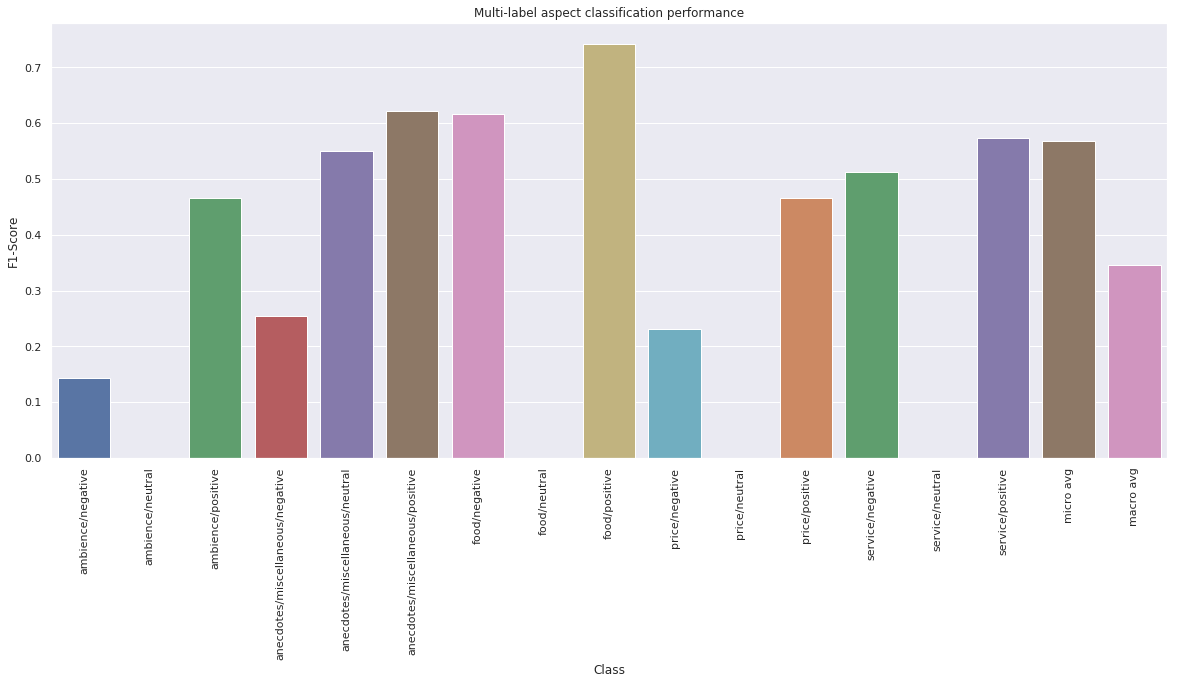

In [28]:
R14_f1s_joint = []
for key in R14_joint_report.keys():
    R14_f1s_joint.append(R14_joint_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(list(R14_joint_report.keys())[:-2], R14_f1s_joint[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

[Text(0.14285714285714285, 0, '0.14'),
 Text(0.0, 1, '0.00'),
 Text(0.4666666666666666, 2, '0.47'),
 Text(0.2545454545454546, 3, '0.25'),
 Text(0.5492957746478874, 4, '0.55'),
 Text(0.6220095693779903, 5, '0.62'),
 Text(0.617283950617284, 6, '0.62'),
 Text(0.0, 7, '0.00'),
 Text(0.7423822714681441, 8, '0.74'),
 Text(0.23076923076923078, 9, '0.23'),
 Text(0.0, 10, '0.00'),
 Text(0.4666666666666667, 11, '0.47'),
 Text(0.5121951219512195, 12, '0.51'),
 Text(0.0, 13, '0.00'),
 Text(0.5739130434782608, 14, '0.57'),
 Text(0.5683060109289617, 15, '0.57'),
 Text(0.34523899286972987, 16, '0.35')]

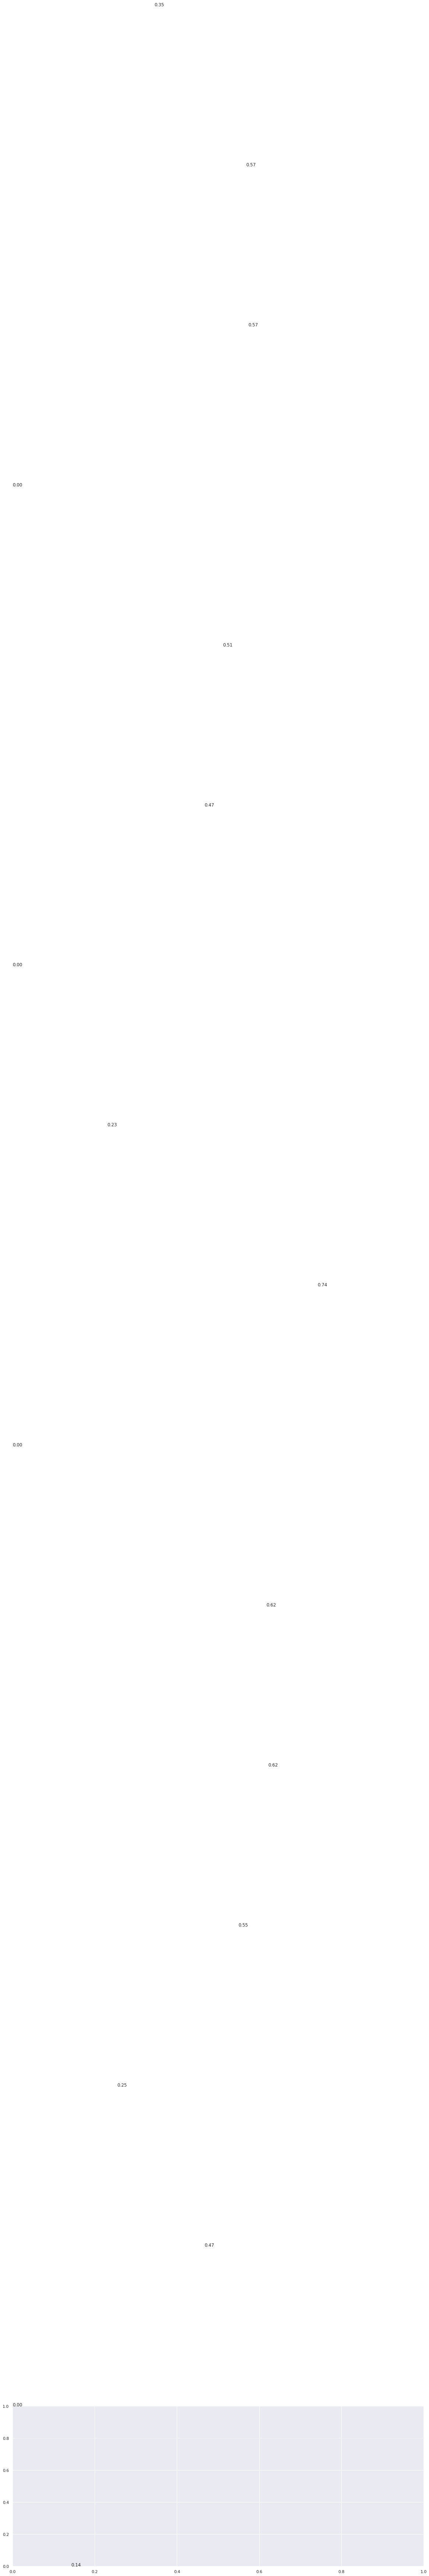

In [29]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(R14_f1s_joint[:-2])]